# Data Science Engineer Challenge
As a part of this challenge, I used the Kaggle lending-club-loans-data to address the problem statement sent

In [1]:
# init and imports
import logging
import setup_logging

# Initiliazing the logger and streaming the logs to stderr so that they get displayed in Jupyter notebook
setup_logging.init_logging()

In [2]:
from db import add_data

# add_data method allows us to append or replace data in a sqlite table
# We can use this method to periodically add more rows of data
add_data(table_name='loan', source_file='/Users/svysyara/Downloads/loan.csv', insert_type='replace')

root - INFO - Loading data from file: /Users/svysyara/Downloads/loan.csv
root - INFO - Added 887379 rows of data to the loan table


In [3]:
import db
import pandas.io.sql as psql

conn = db.connect()
#Loading the loans data to a data frame from the sqlite database
df = psql.read_sql('SELECT * FROM LOAN', con=conn)

#Displaying the top 5 rows of data for Data exploration
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleanup
From initial exploration it is visible that for a few columns there is no data and most values are NULL.
So, let's assume if the data is NULL for more than 90% of rows we can reject the column. Likewise we will also reject rows of data where 50% of values are NULL. We will do the cleanup at the dataframe level only and not make the changes to the original data in the sqlite db. In future, if need be we can write the values derived to a new downstream table w/o affecting the source data.

In [4]:
df_len = len(df.index)

#Dropping columns with 90% or more NULL values
for column in df:
    if df[column].isnull().sum() >= 0.9 * df_len:
        logging.info("Dropping Column: {column}".format(column=column))
        df.drop(column, axis=1, inplace=True)

# Dropping rows with 50% NULL values
df.dropna(axis=0, thresh=int(0.5*len(df.columns)), inplace=True)
logging.info("Dropped {count} row(s) of data".format(count=df_len-len(df.index)))

root - INFO - Dropping Column: annual_inc_joint
root - INFO - Dropping Column: dti_joint
root - INFO - Dropping Column: verification_status_joint
root - INFO - Dropping Column: open_acc_6m
root - INFO - Dropping Column: open_il_6m
root - INFO - Dropping Column: open_il_12m
root - INFO - Dropping Column: open_il_24m
root - INFO - Dropping Column: mths_since_rcnt_il
root - INFO - Dropping Column: total_bal_il
root - INFO - Dropping Column: il_util
root - INFO - Dropping Column: open_rv_12m
root - INFO - Dropping Column: open_rv_24m
root - INFO - Dropping Column: max_bal_bc
root - INFO - Dropping Column: all_util
root - INFO - Dropping Column: inq_fi
root - INFO - Dropping Column: total_cu_tl
root - INFO - Dropping Column: inq_last_12m
root - INFO - Dropped 0 row(s) of data


## Data Visualization
Post data clean-up, I will demonstrate few simple KPIs about the loans data
1. A histogram, showing the distribution of loan amounts thus indicating what are the most likely loan amounts
2. A scatter plot between loan amount and the annual income of the loan receiver

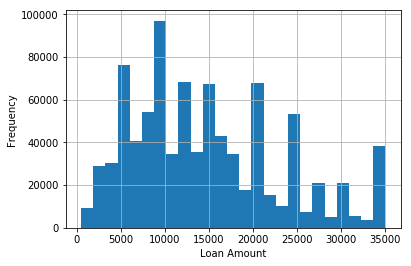

In [6]:
import matplotlib.pyplot as plt

# Histogram showing the frequency of loan amounts
df['loan_amnt'].hist(bins=25)
plt.ylabel('Frequency')
plt.xlabel('Loan Amount')
plt.show()

It seems like most loans were granted at around 10,000 and the counts have reduced as the amount increased. Interestingly, we can also observe that at lower amounts, too the counts were considerably low

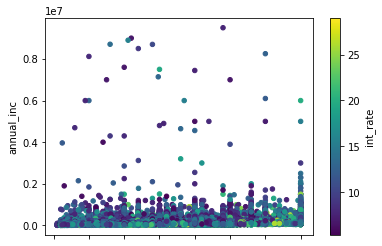

In [10]:
import matplotlib

#Scatter plot between loan amount and annual income
viz2 = df.plot.scatter(x='loan_amnt',
                       y='annual_inc',
                       c='int_rate',
                       colormap='viridis')

Expected some sort of corelation between the annaul income and the loan amount. But it seems like there isn't much corelation between the two metrics. However from the color coding by interest rate we can see that as the loan amount goes higher the color of the dots become lighter, i.e., the interest rate goes higher wrt the loan amount. So a corealtion between the loan amount and annual income seem to exist.